In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import h5py

import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, detstats


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

## Goal:
Pass in an hdf5 file from a library of param spaces and return the average detection probability.

## Steps:
1) Read in file: fobs, hc_ss, hc_bg
2) Produce make a PTA set-up calibrated to 50% hc_bg DP?
3) Given pulsar setup and hdf file, calculate average ss DP and average bg DP
    * Calculate bg DP for each of R strain realizations
    * Build S sky realizations
    * Calculate ss DP for each of S sky realizations for each of R strain realizations.


# Step 1. Read in hdf file

In [3]:
ssfile = h5py.File('//Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss14_n40_r10_f20_d17.5_l5_p0/ss_lib.hdf5', 'r')
print(list(ssfile.keys()))
# print(ssfile['pta_dur'][0])
fobs = ssfile['fobs'][:]
dfobs = ssfile['dfobs'][:]
dur = ssfile['pta_dur'][0]
cad = ssfile['pta_cad'][0]
hc_ss_all = ssfile['hc_ss'][...]
hc_bg_all = ssfile['hc_bg'][...]
shape = hc_ss_all.shape
nsamp, nfreqs, nreals, nloudest = shape[0], shape[1], shape[2], shape[3]
print(nsamp, nfreqs, nreals, nloudest)
ssfile.close()

['dfobs', 'fobs', 'hc_bg', 'hc_ss', 'pta_cad', 'pta_dur', 'sample_params']
40 20 10 5


In [4]:
print('samples (N):', nsamp, '\nreals (R):', nreals, '\nN,F,R,L:', hc_ss_all.shape)

samples (N): 40 
reals (R): 10 
N,F,R,L: (40, 20, 10, 5)


## single realization example

# Step 2. build PTA
Here I am doing this randomly, but really it should be calibrated to hc_bg. Unsure how to do this, if it should be calibrated independently for each strain realization (R), a single pta should be used for all calculations, or positions etc. should be randomized for each iteration. We could even have pta realizations, on top of the strain realizations and the (single source) sky realizations, but that sounds like a nightmare.

The pulsars object is used to store thetas, phis, and sigmas of the pta. With this, use the detect_bg_pta(pulsars, spectra,...) and detect_ss_pta(pulsars,...) functions in detstats. Alternatively, you can just pass in the phis, thetas, and sigmas array to the detect_bg() and detect_ss() functions.

In [5]:
npsrs = 30
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*1.17e-5
# build sim_pta
psrs = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)


calibrate to middle-ish sample

In [6]:
dp_bg = detstats.detect_bg_pta(psrs, fobs, cad, 
                               hc_bg_all[int(nsamp/2)])
print(np.mean(dp_bg))

0.537309458701686


# Step 3. Calculate detstats
Given pulsar setup, and hdf file, calculate average ss DP

Parameters and functions needed:
* def detect_bg_pta(
    - pulsars, 
    - fobs, 
    - cad, 
    - hc_bg, 
    - alpha_0=0.001, 
    - ret_all = False):
* def detect_ss_pta(
    - pulsars, 
    - cad, 
    - dur, 
    - fobs,
    - dfobs, 
    - hc_ss, 
    - hc_bg
    - theta_ss
    - phi_ss=None, 
    - Phi0_ss=None, 
    - iota_ss=None, 
    - psi_ss=None):

## 3.1 BG DP

In [7]:
dp_bg_all = np.zeros((nsamp, nreals)) # (N,R)
for nn in range(nsamp):
    dp_bg_all[nn,:] = detstats.detect_bg_pta(psrs, fobs, cad, hc_bg_all[nn])


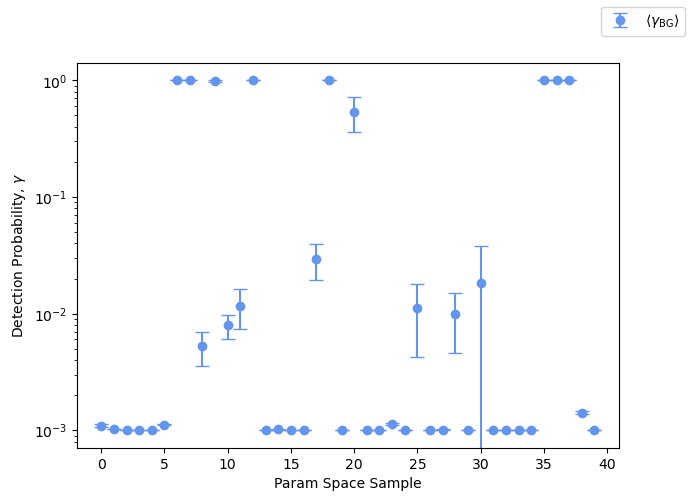

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Param Space Sample')
ax.set_ylabel('Detection Probability, $\gamma$')
ax.errorbar(np.arange(nsamp), np.mean(dp_bg_all, axis=1), 
            yerr = np.std(dp_bg_all, axis=1), linestyle='', 
            marker='o', capsize=5, color='cornflowerblue', 
            label = r'$\langle \gamma_\mathrm{BG} \rangle$')
ax.set_yscale('log')
fig.legend()

## 3.2 SS DP

Build Sky Realizations

In [10]:
nskies = 25 # choose the number of ss sky realizations
theta_ss = np.random.uniform(0, np.pi, size = nfreqs * nskies * nloudest).reshape(nfreqs, nskies, nloudest)
phi_ss = np.random.uniform(0, 2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
Phi0_ss = np.random.uniform(0,2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
iota_ss = np.random.uniform(0,  np.pi, size = theta_ss.size).reshape(theta_ss.shape)
psi_ss = np.random.uniform(0,   np.pi, size = theta_ss.size).reshape(theta_ss.shape)

Calculate ss DP

In [11]:
dp_ss_all = np.zeros((nsamp, nreals, nskies)) # (N,R,S)
for nn in range(nreals):
    dp_ss_all[nn,:,:] = detstats.detect_ss_pta(psrs, cad, dur, fobs, dfobs,
                                               hc_ss_all[nn], hc_bg_all[nn],
                                               theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss,
                                               iota_ss=iota_ss, psi_ss=psi_ss)

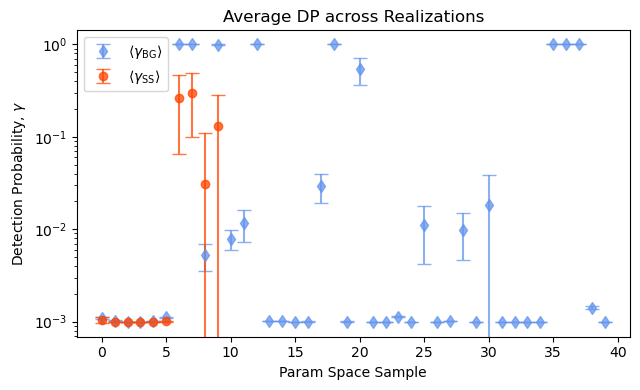

In [60]:
def plot_detprob(dp_ss_all, dp_bg_all):
    """ Plot detection probability for many samples.

    Paramaters
    ----------
    dp_ss_all : (N,R) NDarray
    dp_bg_all : (N,R,S) NDarray
    """
    fig, ax = plt.subplots(figsize=(6.5,4))
    ax.set_xlabel('Param Space Sample')
    ax.set_ylabel('Detection Probability, $\gamma$')
    ax.errorbar(np.arange(nsamp), np.mean(dp_bg_all, axis=1), 
                yerr = np.std(dp_bg_all, axis=1), linestyle='', 
                marker='d', capsize=5, color='cornflowerblue', alpha=0.75,
                label = r'$\langle \gamma_\mathrm{BG} \rangle$')
    ax.errorbar(np.arange(nsamp), np.mean(dp_ss_all, axis=(1,2)),
                yerr = np.std(dp_ss_all, axis=(1,2)), linestyle='', 
                marker='o', capsize=5, color='orangered', alpha=0.75,
                label = r'$\langle \gamma_\mathrm{SS} \rangle$')
    ax.set_yscale('log')
    ax.set_title('Average DP across Realizations')

    ax.legend()
    fig.tight_layout()

    return fig

fig = plot_detprob(dp_ss_all, dp_bg_all)

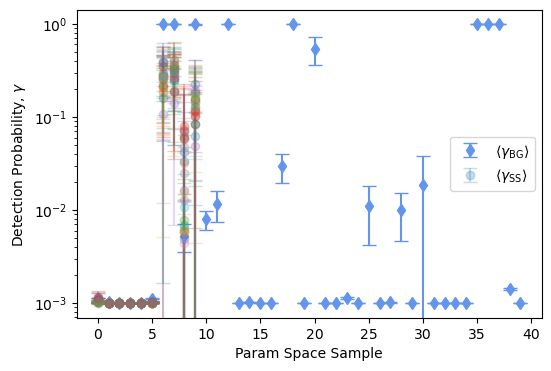

In [56]:
# plot different sky realizations separately
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlabel('Param Space Sample')
ax.set_ylabel('Detection Probability, $\gamma$')
ax.errorbar(np.arange(nsamp), np.mean(dp_bg_all, axis=1), 
            yerr = np.std(dp_bg_all, axis=1), linestyle='', 
            marker='d', capsize=5, color='cornflowerblue', 
            label = r'$\langle \gamma_\mathrm{BG} \rangle$')
for ss in range(nskies): # each color is a sky realization
    if ss == 0: ss_label = r'$\langle \gamma_\mathrm{SS} \rangle$'
    else: ss_label = None
    ax.errorbar(np.arange(nsamp), np.mean(dp_ss_all[:,:,ss], axis=1),
                yerr = np.std(dp_ss_all[:,:,ss], axis=1), linestyle='', 
            marker='o', capsize=5, alpha=0.25,
            label = ss_label)
ax.set_yscale('log')
ax.legend()

## Count realizations with detections

In [21]:
def detfrac_from_reals(dp_ss_all, dp_bg_all, thresh=0.5):
    """ 
    Calculate how many realizations have a detections, to get 
    the detection probability for a sample.

    Parameters
    ----------
    dp_ss_all : (N, R, S) NDarray
    dp_bg_all : (N, R) NDarray
    thresh : scalar
        threshold DP to count as a detection

    Returns
    -------
    ss_detfrac : (N,) NDarray
        Fraction of realizations with an ss DP above thresh.
    bg_detfrac : (N,) NDarray
        Fraction of realizations with a bg DP above thresh.
    
    """
    nsamp = len(dp_ss_all)
    nreals = len(dp_ss_all[0])
    nskies = len(dp_ss_all[0,0])
    bg_detfrac = np.zeros(nsamp)
    ss_detfrac = np.zeros(nsamp)
    for nn in range(nsamp):
        count_bg = 0
        count_ss = 0
        for rr in range(nreals):
            if (dp_bg_all[nn,rr] > thresh):
                count_bg += 1
            for ss in range(nskies):
                if (dp_ss_all[nn,rr,ss] > thresh):
                    count_ss += 1
        bg_detfrac[nn] = count_bg/nreals
        ss_detfrac[nn] = count_ss/(nreals*nskies)

    return ss_detfrac, bg_detfrac

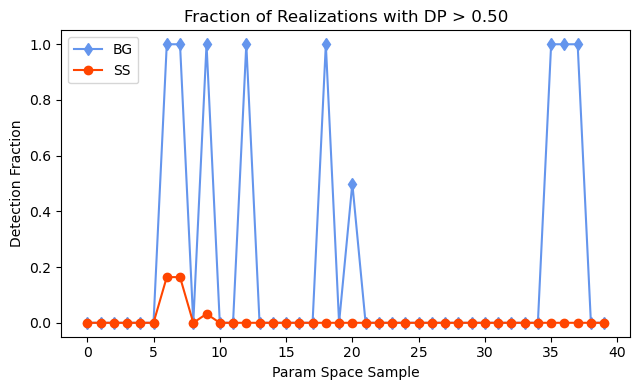

In [59]:
thresh=0.5
ss_detfrac, bg_detfrac = detfrac_from_reals(dp_ss_all, dp_bg_all, thresh)
def plot_detfrac(df_ss, df_bg, thresh):
    fig, ax = plt.subplots(figsize=(6.5,4))
    ax.plot(np.arange(nsamp), df_bg, color='cornflowerblue', label='BG',
            marker='d')
    ax.plot(np.arange(nsamp), df_ss, color='orangered', label='SS',
            marker='o')
    ax.set_xlabel('Param Space Sample')
    ax.set_ylabel('Detection Fraction')
    ax.set_title('Fraction of Realizations with DP > %0.2f' % thresh)
    ax.legend()
    fig.tight_layout()
    return fig
fig = plot_detfrac(ss_detfrac, bg_detfrac, thresh)

# Streamline
 Do it all for a given pta

In [32]:
def run_psr_calculations(hc_ss_all, hc_bg_all, npsrs = 30, sigma = 1.17e-5, 
                         nskies = 25):
    shape = hc_ss_all.shape
    nsamp, nfreqs, nreals, nloudest = shape[0], shape[1], shape[2], shape[3]

    # build PTA
    phis = np.random.uniform(0, 2*np.pi, size = npsrs)
    thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
    sigmas = np.ones_like(phis)*sigma
    psrs = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)
    
    # Calculate background DP
    dp_bg_all = np.zeros((nsamp, nreals)) # (N,R)
    for nn in range(nsamp):
        dp_bg_all[nn,:] = detstats.detect_bg_pta(psrs, fobs, cad, hc_bg_all[nn])

    # Build ss skies
    theta_ss = np.random.uniform(0, np.pi, size = nfreqs * nskies * nloudest).reshape(nfreqs, nskies, nloudest)
    phi_ss = np.random.uniform(0, 2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    Phi0_ss = np.random.uniform(0,2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    iota_ss = np.random.uniform(0,  np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    psi_ss = np.random.uniform(0,   np.pi, size = theta_ss.size).reshape(theta_ss.shape)

    # Calculate single source DP
    dp_ss_all = np.zeros((nsamp, nreals, nskies)) # (N,R,S)
    for nn in range(nreals):
        dp_ss_all[nn,:,:] = detstats.detect_ss_pta(psrs, cad, dur, fobs, dfobs,
                                                hc_ss_all[nn], hc_bg_all[nn],
                                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss,
                                                iota_ss=iota_ss, psi_ss=psi_ss)
    return dp_ss_all, dp_bg_all
        

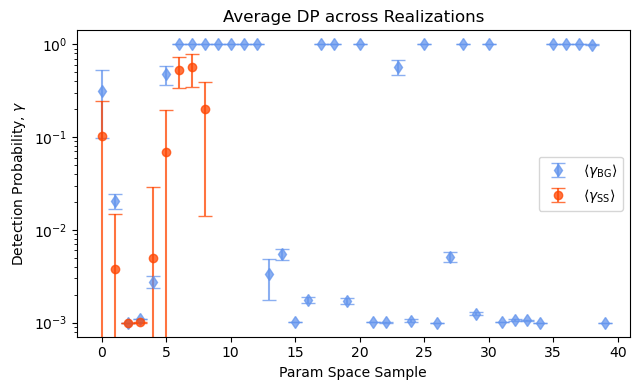

In [62]:
dp_ss_psr, dp_bg_psr = run_psr_calculations(hc_ss_all, hc_bg_all, npsrs = 30, sigma = 1e-6,
                                  nskies = 25)
fig1 = plot_detprob(dp_ss_psr, dp_bg_psr)

In [54]:
print(np.min(dp_ss_psr))

0.0


where are the rest of my single sources? possibly too low to detect

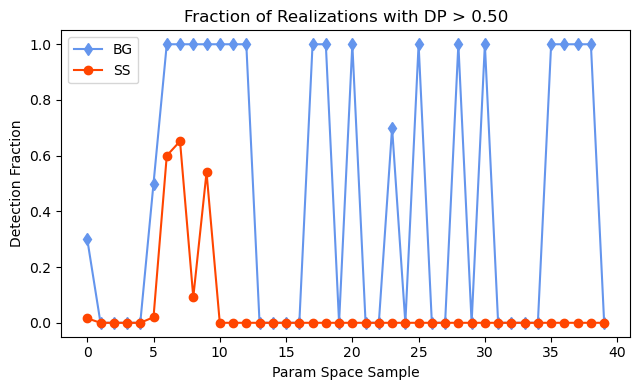

In [63]:
thresh=0.5
df_ss_psr, df_bg_psr = detfrac_from_reals(dp_ss_psr, dp_bg_psr, thresh)
fig2 = plot_detfrac(df_ss_psr, df_bg_psr, thresh)

Try another pta, 40 pulsars, 5e-7 sigma

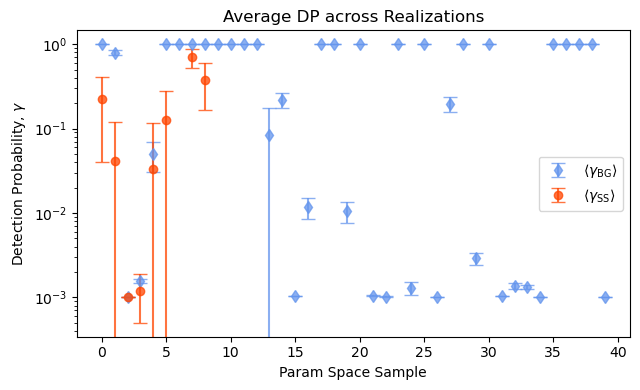

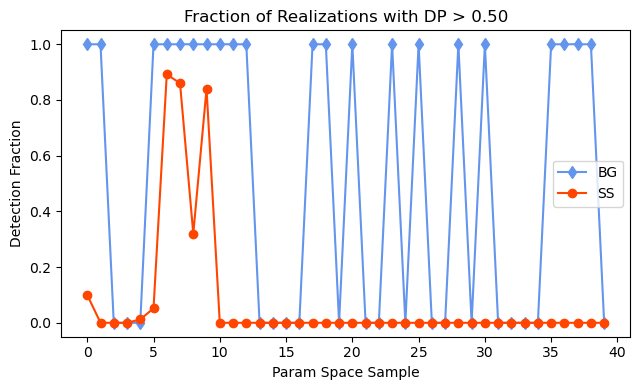

In [64]:
dp_ss_psr40, dp_bg_psr40 = run_psr_calculations(hc_ss_all, hc_bg_all, npsrs = 40, sigma = 5e-7,
                                  nskies = 25)
fig1 = plot_detprob(dp_ss_psr40, dp_bg_psr40)
thresh=0.5
df_ss_psr40, df_bg_psr40 = detfrac_from_reals(dp_ss_psr40, dp_bg_psr40, thresh)
fig2 = plot_detfrac(df_ss_psr40, df_bg_psr40, thresh)

# Appendix: Regular Old Detection Statistic Calculation

### A.1 build sam and calculate gws

In [7]:
dur = 15.0*YR
cad = .2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
dfobs = np.diff(fobs_edges)
sam = holo.sam.Semi_Analytic_Model() 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hc_ss_one, hc_bg_one = sam.ss_gwb(fobs_edges, realize=20, loudest=5)

SS 1: 
Current memory usage: max=0.30 GB, RSS=0.30 GB, VMS=391.06 GB
21:50:35 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
21:50:35 INFO : Stalled SAM bins based on GMT: 2.58e+05/6.53e+05 = 3.96e-01 [sam.py:static_binary_density]
21:50:35 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
21:50:35 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.29e-61, 8.58e-04, 1.48e-02, 2.79e-02, 4.47e-02) [sam.py:static_binary_density]
21:50:51 INFO : Scatter added after 15.653541 sec [sam.py:static_binary_density]
21:50:51 INFO : 	dens aft: (6.72e-29, 2.61e-15, 3.78e-09, 1.03e-03, 1.50e-02, 2.80e-02, 4.26e-02) [sam.py:static_binary_density]
21:50:51 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.7939e-03 [sam.py:static_binary_density]
21:50:51 INFO : zeroing out 2.58e+05/6.53e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
21:50:51 INFO : fraction of coalesced binaries: 3.28e+06/2.41e+07 = 1.36e-01 [sam.py:dynamic_binary_nu

### A.2 build pta

In [8]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*5.2e-6
# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)


### A.3 calculate bg DP

[0.38814156 0.4002113  0.37303875 0.35418402 0.39490187 0.35907786
 0.41648708 0.3757482  0.30290582 0.33696798 0.46466489 0.32007381
 0.41824596 0.44965024 0.40410157 0.41513028 0.39436741 0.3961866
 0.46446852 0.33006764]
[0.38814156 0.4002113  0.37303875 0.35418402 0.39490187 0.35907786
 0.41648708 0.3757482  0.30290582 0.33696798 0.46466489 0.32007381
 0.41824596 0.44965024 0.40410157 0.41513028 0.39436741 0.3961866
 0.46446852 0.33006764]


Text(0.5, 1.0, 'F,R,L =(37, 20, 5)\nsigmas=5.20e-06')

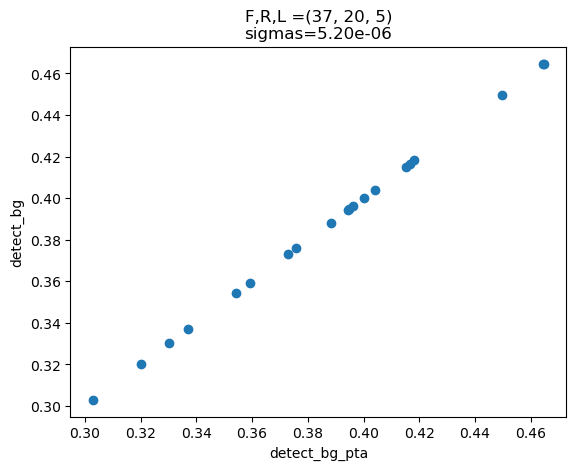

In [9]:
dp_bg1 = detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg_one)
dp_bg2 = detstats.detect_bg(thetas, phis, sigmas, fobs, cad, hc_bg_one)
plt.scatter(dp_bg1, dp_bg2)
print(dp_bg1)
print(dp_bg2)
plt.xlabel('detect_bg_pta')
plt.ylabel('detect_bg')
plt.title(('F,R,L ='+ str(hc_ss_one.shape)+'\nsigmas=%.2e' %sigmas[0]))


### A.4 build ss sky realizations

In [10]:
print(hc_ss_one.shape)

(37, 20, 5)


In [11]:
S = 15
F = len(fobs)
L = len(hc_ss_one[0,0])
theta_ss = np.random.uniform(0, np.pi, size=F*S*L).reshape(F,S,L)
phi_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
Phi0_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
iota_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)
psi_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)

### A.5 calculate ss DP

In [12]:
dp_ss1 = detstats.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss_one, hc_bg_one,
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, iota_ss=iota_ss, psi_ss=psi_ss)
dp_ss2 = detstats.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss_one, hc_bg_one,
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, iota_ss=iota_ss, psi_ss=psi_ss)

gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.
gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.


(20, 15) 1.03e-03, 1.05e-03, 1.07e-03, 1.39e-03, 6.84e-03, 4.85e-02, 5.05e-01
(20, 15) 1.03e-03, 1.05e-03, 1.07e-03, 1.39e-03, 6.84e-03, 4.85e-02, 5.05e-01


Text(0.5, 1.0, 'F,R,L =(37, 20, 5)\nsigmas=5.20e-06')

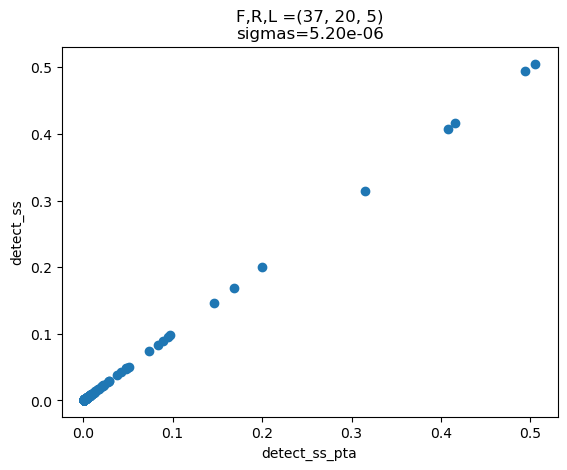

In [13]:
plt.scatter(dp_ss1, dp_ss2)
print(dp_ss1.shape, utils.stats(dp_ss1))
print(dp_ss2.shape, utils.stats(dp_ss2))
plt.xlabel('detect_ss_pta')
plt.ylabel('detect_ss')
plt.title(('F,R,L ='+ str(hc_ss_one.shape)+'\nsigmas=%.2e' %sigmas[0]))


In [14]:
print(dp_ss1.shape) # (R, S)

(20, 15)


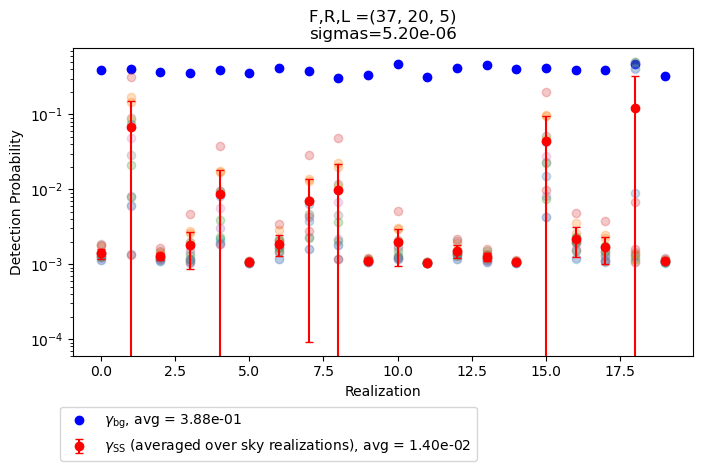

In [15]:
def plot_dpbg_dpss(dpbg, dpss, title):
    R = len(dpbg)
    fig, ax = plt.subplots(figsize = (8,4))
    ax.scatter(np.arange(R), dpbg, label='$\gamma_\mathrm{bg}$, avg = %.2e' % np.mean(dpbg), color='blue')
    ax.errorbar(np.arange(R), np.mean(dpss, axis=1), yerr=np.std(dpss, axis=1), capsize=3,
                linestyle='', marker='o',
                color='red', label = '$\gamma_\mathrm{SS}$ (averaged over sky realizations), avg = %.2e' 
                % np.mean(dpss))
    for ss in range(len(dpss[0])):
        ax.scatter(np.arange(R), dpss[:,ss], alpha=0.25)

    fig.legend(bbox_to_anchor=(0.1,0), bbox_transform=fig.transFigure, loc='upper left')
    ax.set_xlabel('Realization')
    ax.set_ylabel('Detection Probability')
    ax.set_yscale('log')
    ax.set_title(title)
    # plt.ylim(0,1)
    return fig

fig = plot_dpbg_dpss(dp_bg1, dp_ss1, title = ('F,R,L ='+ str(hc_ss_one.shape)+'\nsigmas=%.2e' %sigmas[0]))

### A.6 %timeit

In [16]:
%timeit detstats.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss_one, hc_bg_one,\
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, iota_ss=iota_ss, psi_ss=psi_ss) 

gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.
gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.
gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, 

In [17]:
%timeit detstats.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss_one, hc_bg_one, \
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, iota_ss=iota_ss, psi_ss=psi_ss)

gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.
gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, setting to 0.
gamma_ssi[0,18,10,0] is nan, setting to 0.
gamma_ssi[0,18,11,0] is nan, setting to 0.
gamma_ssi[0,18,13,0] is nan, setting to 0.
gamma_ssi[0,18,1,0] is nan, setting to 0.
gamma_ssi[0,18,2,0] is nan, setting to 0.
gamma_ssi[0,18,5,0] is nan, setting to 0.
gamma_ssi[0,18,6,0] is nan, setting to 0.
gamma_ssi[0,18,7,0] is nan, setting to 0.
gamma_ssi[0,18,8,0] is nan, 

In [18]:
%timeit detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg_one)
%timeit detstats.detect_bg(thetas, phis, sigmas, fobs, cad, hc_bg_one)


20.8 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.2 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## A.7 Vary L
### L = 100

In [24]:
def calculate_dps(pulsars, hc_ss, hc_bg, S=15):
    F = len(hc_ss)
    R = len(hc_ss[0])
    L = len(hc_ss[0,0])

    # build ss sky realizations        
    theta_ss = np.random.uniform(0, np.pi, size=F*S*L).reshape(F,S,L)
    phi_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
    Phi0_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
    iota_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    psi_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)

    dp_bg = detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg)
    dp_ss = detstats.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss)
    return dp_bg, dp_ss 

def time_dps(pulsars, hc_ss, hc_bg, S=15):
    F = len(hc_ss)
    R = len(hc_ss[0])
    L = len(hc_ss[0,0])

    # build ss sky realizations        
    theta_ss = np.random.uniform(0, np.pi, size=F*S*L).reshape(F,S,L)
    phi_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
    Phi0_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
    iota_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    psi_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)

    %timeit detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg)
    %timeit detstats.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss, hc_bg,\
                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss, \
                                iota_ss=iota_ss, psi_ss=psi_ss)


In [20]:
hc_ss_L100, hc_bg_L100 = sam.ss_gwb(fobs_edges, realize=20, loudest=100)
dp_bg_L100, dp_ss_L100 = calculate_dps(pulsars, hc_ss_L100, hc_bg_L100, S=15)

SS 1: 
Current memory usage: max=2.55 GB, RSS=1.26 GB, VMS=392.12 GB
21:53:16 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
21:53:17 INFO : fraction of coalesced binaries: 3.28e+06/2.41e+07 = 1.36e-01 [sam.py:dynamic_binary_number]
21:53:17 INFO : stalled binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=2.55 GB, RSS=1.24 GB, VMS=392.12 GB
SS 3: 
Current memory usage: max=2.55 GB, RSS=1.41 GB, VMS=392.30 GB
21:53:21 WARNING : Using `redz_prime` for redshift (includes galaxy merger time, but not evolution time) [sam.py:ss_gwb]
SS 4: 
Current memory usage: max=2.55 GB, RSS=1.47 GB, VMS=392.48 GB
gamma_ssi[0,2,2,0] is nan, setting to 0.
gamma_ssi[0,2,4,0] is nan, setting to 0.
gamma_ssi[0,2,10,0] is nan, setting to 0.
gamma_ssi[0,2,12,0] is nan, setting to 0.
gamma_ssi[0,2,13,0] is nan, setting to 0.
gamma_ssi[0,3,13,0] is nan, setting to 0.
gamma_ssi[0,10,2,0] is nan, setting to

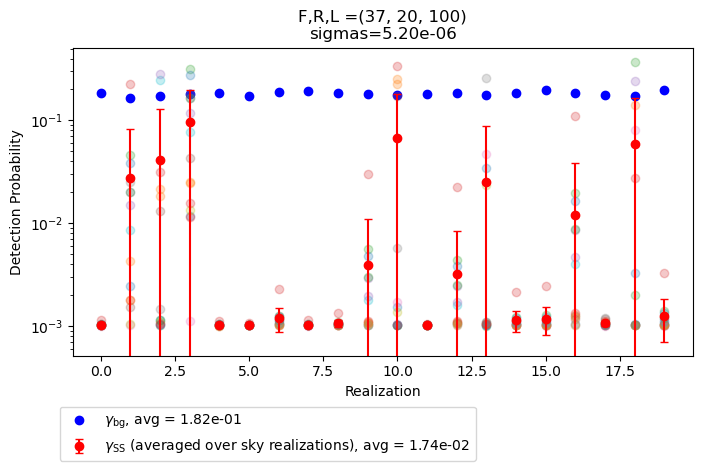

In [21]:
fig = plot_dpbg_dpss(dp_bg_L100, dp_ss_L100, 
                     title = ('F,R,L ='+ str(hc_ss_L100.shape)+'\nsigmas=%.2e' %sigmas[0]))

### L = 1

SS 1: 
Current memory usage: max=2.55 GB, RSS=0.75 GB, VMS=392.13 GB
21:55:47 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
21:55:48 INFO : fraction of coalesced binaries: 3.28e+06/2.41e+07 = 1.36e-01 [sam.py:dynamic_binary_number]
21:55:48 INFO : stalled binaries are not being accounted for in `dynamic_binary_number`! [sam.py:dynamic_binary_number]
SS 2: 
Current memory usage: max=2.55 GB, RSS=0.53 GB, VMS=392.13 GB
SS 3: 
Current memory usage: max=2.55 GB, RSS=0.65 GB, VMS=392.31 GB
21:55:53 WARNING : Using `redz_prime` for redshift (includes galaxy merger time, but not evolution time) [sam.py:ss_gwb]
SS 4: 
Current memory usage: max=2.55 GB, RSS=1.41 GB, VMS=392.57 GB
gamma_ssi[0,1,1,0] is nan, setting to 0.
gamma_ssi[0,1,3,0] is nan, setting to 0.
gamma_ssi[0,1,5,0] is nan, setting to 0.
gamma_ssi[0,1,10,0] is nan, setting to 0.
gamma_ssi[0,1,11,0] is nan, setting to 0.
gamma_ssi[0,1,13,0] is nan, setting to 0.
gamma_ssi[0,1,14,0] is nan, setting to 

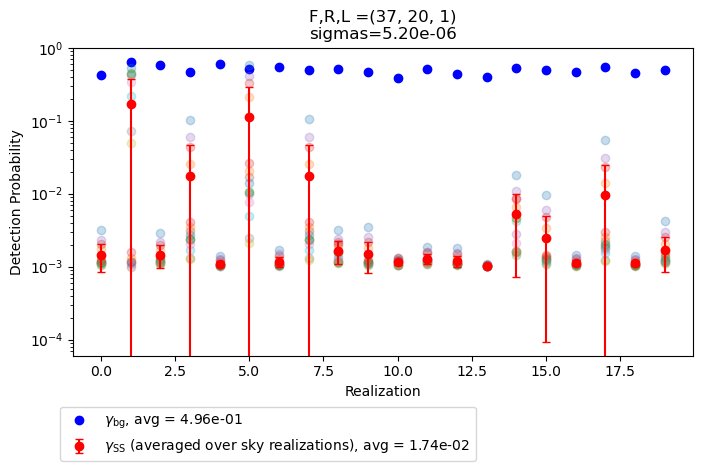

In [22]:
hc_ss_L1, hc_bg_L1 = sam.ss_gwb(fobs_edges, realize=20, loudest=1)
dp_bg_L1, dp_ss_L1 = calculate_dps(pulsars, hc_ss_L1, hc_bg_L1, S=15)
fig = plot_dpbg_dpss(dp_bg_L1, dp_ss_L1, 
                     title = ('F,R,L ='+ str(hc_ss_L1.shape)+'\nsigmas=%.2e' %sigmas[0]))

## A.8 % Timeit 

In [25]:
time_dps(pulsars, hc_ss_L1, hc_bg_L1, S=15)

21.6 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
gamma_ssi[0,1,0,0] is nan, setting to 0.
gamma_ssi[0,1,2,0] is nan, setting to 0.
gamma_ssi[0,1,5,0] is nan, setting to 0.
gamma_ssi[0,1,6,0] is nan, setting to 0.
gamma_ssi[0,1,7,0] is nan, setting to 0.
gamma_ssi[0,1,8,0] is nan, setting to 0.
gamma_ssi[0,1,11,0] is nan, setting to 0.
gamma_ssi[0,1,12,0] is nan, setting to 0.
gamma_ssi[0,1,13,0] is nan, setting to 0.
gamma_ssi[0,5,5,0] is nan, setting to 0.
gamma_ssi[0,5,11,0] is nan, setting to 0.
gamma_ssi[0,5,12,0] is nan, setting to 0.
gamma_ssi[0,1,0,0] is nan, setting to 0.
gamma_ssi[0,1,2,0] is nan, setting to 0.
gamma_ssi[0,1,5,0] is nan, setting to 0.
gamma_ssi[0,1,6,0] is nan, setting to 0.
gamma_ssi[0,1,7,0] is nan, setting to 0.
gamma_ssi[0,1,8,0] is nan, setting to 0.
gamma_ssi[0,1,11,0] is nan, setting to 0.
gamma_ssi[0,1,12,0] is nan, setting to 0.
gamma_ssi[0,1,13,0] is nan, setting to 0.
gamma_ssi[0,5,5,0] is nan, setting to 0.
gamma_ssi[0,5,11,0] 

In [26]:
time_dps(pulsars, hc_ss_L100, hc_bg_L100, S=15)

21 ms ± 655 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
gamma_ssi[0,2,0,0] is nan, setting to 0.
gamma_ssi[0,2,3,0] is nan, setting to 0.
gamma_ssi[0,2,5,0] is nan, setting to 0.
gamma_ssi[0,2,7,0] is nan, setting to 0.
gamma_ssi[0,2,13,0] is nan, setting to 0.
gamma_ssi[0,2,14,0] is nan, setting to 0.
gamma_ssi[0,10,0,0] is nan, setting to 0.
gamma_ssi[0,10,1,0] is nan, setting to 0.
gamma_ssi[0,10,3,0] is nan, setting to 0.
gamma_ssi[0,10,4,0] is nan, setting to 0.
gamma_ssi[0,10,5,0] is nan, setting to 0.
gamma_ssi[0,10,7,0] is nan, setting to 0.
gamma_ssi[0,10,8,0] is nan, setting to 0.
gamma_ssi[0,10,13,0] is nan, setting to 0.
gamma_ssi[0,10,14,0] is nan, setting to 0.
gamma_ssi[0,13,0,0] is nan, setting to 0.
gamma_ssi[0,13,1,0] is nan, setting to 0.
gamma_ssi[0,13,3,0] is nan, setting to 0.
gamma_ssi[0,13,4,0] is nan, setting to 0.
gamma_ssi[0,13,5,0] is nan, setting to 0.
gamma_ssi[0,13,7,0] is nan, setting to 0.
gamma_ssi[0,13,8,0] is nan, setting to 0.
gamma_ssi[